In [9]:
# Load pickled data
import pickle

training_file = 'train.p'
validation_file= 'valid.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [10]:
#Data Summary

# Number of training examples
n_train = len(X_train)

# Number of testing examples.
n_test = len(X_test)

# Traffic sign image shape
image_shape = X_train[0].shape

# Classes/labels in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


31


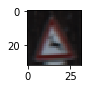

In [11]:
### Data visualization

import matplotlib.pyplot as plt

%matplotlib inline

import random
import numpy as np


index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image, cmap="gray")
print(y_train[index])

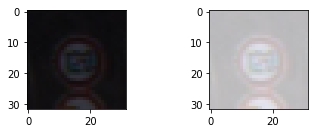

In [12]:
### Data Preprocessing

from sklearn.utils import shuffle

#shuffle
X_train, y_train = shuffle(X_train, y_train)

#store unnormalized dataset as backup
X_train_back = X_train
X_test_back = X_test

# Normalise input
X_train = (X_train - X_train.mean()) / (np.max(X_train) - np.min(X_train))
X_test = (X_test - X_test.mean()) / (np.max(X_test) - np.min(X_test))

index = random.randint(0, len(X_train))
plt.subplot(2,2,1)
plt.imshow(X_train_back[index])
plt.subplot(2,2,2)
plt.imshow(X_train[index])

In [18]:
### Model architecture

import tensorflow as tf

EPOCHS = 65
BATCH_SIZE = 128

from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1

    # SOLUTION: Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x18.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 18), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(18))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x18. Output = 14x14x18.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x48.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 18, 48), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(48))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b

    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x48. Output = 5x5x48.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x48. Output = 1200.
    fc0   = flatten(conv2)

    # SOLUTION: Layer 3: Fully Connected. Input = 1200. Output = 400.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(1200, 400), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(400))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b

    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = 400. Output = 120.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(120))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b

    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)

    # SOLUTION: Layer 5: Fully Connected. Input = 120. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(120, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b

    return logits

In [19]:
### Train Model

x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.787

EPOCH 2 ...
Validation Accuracy = 0.831

EPOCH 3 ...
Validation Accuracy = 0.841

EPOCH 4 ...
Validation Accuracy = 0.866

EPOCH 5 ...
Validation Accuracy = 0.868

EPOCH 6 ...
Validation Accuracy = 0.892

EPOCH 7 ...
Validation Accuracy = 0.888

EPOCH 8 ...
Validation Accuracy = 0.904

EPOCH 9 ...
Validation Accuracy = 0.891

EPOCH 10 ...
Validation Accuracy = 0.896

EPOCH 11 ...
Validation Accuracy = 0.901

EPOCH 12 ...
Validation Accuracy = 0.908

EPOCH 13 ...
Validation Accuracy = 0.914

EPOCH 14 ...
Validation Accuracy = 0.902

EPOCH 15 ...
Validation Accuracy = 0.883

EPOCH 16 ...
Validation Accuracy = 0.910

EPOCH 17 ...
Validation Accuracy = 0.910

EPOCH 18 ...
Validation Accuracy = 0.899

EPOCH 19 ...
Validation Accuracy = 0.901

EPOCH 20 ...
Validation Accuracy = 0.901

EPOCH 21 ...
Validation Accuracy = 0.929

EPOCH 22 ...
Validation Accuracy = 0.926

EPOCH 23 ...
Validation Accuracy = 0.924

EPOCH 24 ...
Validation Accura

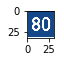

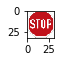

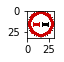

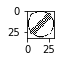

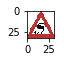

In [21]:
### Load images
import cv2, os
import matplotlib.image as mpimg
from skimage import transform
imgs = []
for file in os.listdir("test_signs"):
    if file.endswith(".jpg"):
        img = mpimg.imread(file)
        img = cv2.resize(img, (32, 32)) 
        imgs.append(img)
        plt.figure(figsize=(0.5,0.5))
        plt.imshow(img)
      

Classifications


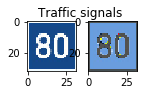

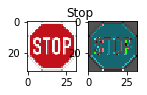

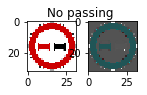

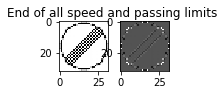

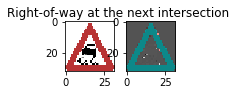

In [22]:
### Run prediction
import pandas as pd



images = np.array(imgs)

images_norm = (images - images.mean()) / (np.max(images) - np.min(images))


with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    sess = tf.get_default_session()
    classification = sess.run(tf.nn.softmax(logits), feed_dict={x: images_norm, y: batch_y})
    print("Classifications")

    classifications=(np.argmax(classification,axis=1))
    
    names=pd.read_csv('signnames.csv', sep=',')
    
    test_index=0
    
    for i in classifications:
        plt.figure(figsize=(2,2))
        plt.suptitle(names[names['ClassId']==i]['SignName'][i])
        plt.subplot(2,2,1)
        plt.imshow(imgs[test_index])
        plt.subplot(2,2,2)
        plt.imshow(images_norm[test_index])
        test_index= test_index+1

In [61]:
### Calculate the accuracy 
60% correct.  It missed the 80MPH sign and got slippery road wrong

In [24]:
### Top five softmax probabilities for the predictions 

import heapq

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    sess = tf.get_default_session()
    tops = sess.run((tf.nn.top_k(tf.constant(classification), k=3)))
    print("Top 3 Classifications")

    print(tops)

Top 3 Classifications
TopKV2(values=array([[  9.99853730e-01,   1.34728107e-04,   9.34601940e-06],
       [  9.99999642e-01,   4.02403174e-07,   1.55934900e-12],
       [  1.00000000e+00,   3.61195284e-37,   0.00000000e+00],
       [  1.00000000e+00,   3.90288468e-10,   3.16726165e-13],
       [  1.00000000e+00,   2.58035725e-18,   3.41035811e-24]], dtype=float32), indices=array([[26,  8,  0],
       [14,  1, 13],
       [ 9, 41,  0],
       [32,  6, 41],
       [11, 30, 23]]))
